In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense

import cv2
import pandas as pd
import dlib

In [130]:
for i in range(500):
    globals()['land'+str(i)] = pd.read_csv('./dlib500/train/%s.csv'%i)
    globals()['land'+str(i)] = np.array(globals()['land'+str(i)])
    
    tr_x = globals()['land'+str(i)][:, 0]
    tr_y = globals()['land'+str(i)][:, 1]
    
    tr_cx = ((min(tr_x)+max(tr_x)) / 2)        #dlib_rect 중점
    tr_cy = ((min(tr_y)+max(tr_y)) / 2)
    
    tr_h = max(tr_y)-min(tr_y)    #종축 길이
    
    tr_x -= tr_cx
    tr_y -= tr_cy
    
    norm_try = (tr_y - min(tr_y)) / (tr_h *1.5)
    
    globals()['train_norm'+str(i)] = norm_try

In [131]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye'+str(i)] = globals()['train_norm'+str(i)][36:48].flatten()
    globals()['norm_nose'+str(i)] = globals()['train_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth'+str(i)] = globals()['train_norm'+str(i)][48:].flatten()
    globals()['norm_jaws'+str(i)] = globals()['train_norm'+str(i)][:17].flatten()

In [132]:
train_x = np.zeros((500, len(norm_eye0)))   #eye
for i in range(500):
    for j in range(len(norm_eye0)):
        train_x[i][j] = globals()['norm_eye'+str(i)][j]   

In [133]:
try_eye = pd.read_csv('./DataSet500/train/csv/train.csv')
try_eye = try_eye.iloc[:, 17]

In [134]:
for i in range(500):
    globals()['mark'+str(i)] = pd.read_csv('./dlib500/test/%s.csv'%i)
    globals()['mark'+str(i)] = np.array(globals()['mark'+str(i)])
    
    te_x = globals()['mark'+str(i)][:, 0]
    te_y = globals()['mark'+str(i)][:, 1]
    
    te_cx = ((min(te_x)+max(te_x)) / 2)
    te_cy = ((min(te_y)+max(te_y)) / 2)

    te_h = max(te_y)-min(te_y)
    
    
    te_x -= te_cx
    te_y -= te_cy

    norm_tey = (te_y - min(te_y)) / (te_h *1.5)
    
    globals()['test_norm'+str(i)] = norm_tey

In [135]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye2'+str(i)] = globals()['test_norm'+str(i)][36:48].flatten()
    globals()['norm_nose2'+str(i)] = globals()['test_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth2'+str(i)] = globals()['test_norm'+str(i)][48:].flatten()
    globals()['norm_jaws2'+str(i)] = globals()['test_norm'+str(i)][:17].flatten()

In [136]:
test_x = np.zeros((500, len(norm_eye20)))
for i in range(500):
    for j in range(len(norm_eye20)):
        test_x[i][j] = globals()['norm_eye2'+str(i)][j]  

In [137]:
tey_eye = pd.read_csv('./DataSet500/test/csv/test.csv')
tey_eye = tey_eye.iloc[:, 17]

In [139]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 0.002
N_EPOCHS = 500
N_BATCH = 32

In [140]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, try_eye))\
                                .shuffle(500)\
                                .batch(N_BATCH, drop_remainder=True)\
                                .repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, tey_eye)).batch(N_BATCH)

In [141]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=8, activation='relu', input_shape=(12,)))
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=4, activation='relu'))
    model.add(keras.layers.Dense(units=1))
    
    return model

In [142]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [143]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 8)                 104       
                                                                 
 dense_40 (Dense)            (None, 8)                 72        
                                                                 
 dense_41 (Dense)            (None, 4)                 36        
                                                                 
 dense_42 (Dense)            (None, 1)                 5         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [144]:
from keras.callbacks import ReduceLROnPlateau
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            min_delta=0.0001,
                            cooldown=0,
                            min_lr=0,
                            mode='auto')

In [145]:
steps_per_epoch = train_x.shape[0]
validation_steps = int(np.ceil(test_x.shape[0]/N_BATCH))

In [146]:
history = model.fit(train_dataset,
                   epochs=N_EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_data = test_dataset,
                   validation_steps = validation_steps,
                   callbacks=[reduceLR])

Epoch 1/500
500/500 [==============================] - 1s 707us/step - loss: 0.0910 - val_loss: 0.0857 - lr: 0.0020
Epoch 2/500
500/500 [==============================] - 0s 603us/step - loss: 0.0853 - val_loss: 0.0784 - lr: 0.0020
Epoch 3/500
500/500 [==============================] - 0s 601us/step - loss: 0.0726 - val_loss: 0.0619 - lr: 0.0020
Epoch 4/500
500/500 [==============================] - 0s 601us/step - loss: 0.0656 - val_loss: 0.0619 - lr: 0.0020
Epoch 5/500
500/500 [==============================] - 0s 599us/step - loss: 0.0640 - val_loss: 0.0600 - lr: 0.0020
Epoch 6/500
500/500 [==============================] - 0s 605us/step - loss: 0.0620 - val_loss: 0.0547 - lr: 0.0020
Epoch 7/500
500/500 [==============================] - 0s 595us/step - loss: 0.0612 - val_loss: 0.0593 - lr: 0.0020
Epoch 8/500
500/500 [==============================] - 0s 593us/step - loss: 0.0596 - val_loss: 0.0530 - lr: 0.0020
Epoch 9/500
500/500 [==============================] - 0s 593us/step - l

500/500 [==============================] - 0s 605us/step - loss: 0.0487 - val_loss: 0.0469 - lr: 0.0010
Epoch 72/500
500/500 [==============================] - 0s 597us/step - loss: 0.0494 - val_loss: 0.0466 - lr: 0.0010
Epoch 73/500
500/500 [==============================] - 0s 595us/step - loss: 0.0493 - val_loss: 0.0463 - lr: 0.0010
Epoch 74/500
500/500 [==============================] - 0s 595us/step - loss: 0.0487 - val_loss: 0.0464 - lr: 0.0010
Epoch 75/500
500/500 [==============================] - 0s 591us/step - loss: 0.0488 - val_loss: 0.0467 - lr: 0.0010
Epoch 76/500
500/500 [==============================] - 0s 593us/step - loss: 0.0487 - val_loss: 0.0464 - lr: 0.0010
Epoch 77/500
500/500 [==============================] - 0s 595us/step - loss: 0.0496 - val_loss: 0.0466 - lr: 0.0010
Epoch 78/500
500/500 [==============================] - 0s 597us/step - loss: 0.0490 - val_loss: 0.0495 - lr: 0.0010
Epoch 79/500
500/500 [==============================] - 0s 601us/step - loss:

Epoch 139/500
500/500 [==============================] - 0s 595us/step - loss: 0.0473 - val_loss: 0.0469 - lr: 1.5625e-05
Epoch 140/500
500/500 [==============================] - 0s 593us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.5625e-05
Epoch 141/500
500/500 [==============================] - 0s 599us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 7.8125e-06
Epoch 142/500
500/500 [==============================] - 0s 593us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 7.8125e-06
Epoch 143/500
500/500 [==============================] - 0s 593us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 7.8125e-06
Epoch 144/500
500/500 [==============================] - 0s 601us/step - loss: 0.0474 - val_loss: 0.0467 - lr: 7.8125e-06
Epoch 145/500
500/500 [==============================] - 0s 599us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 7.8125e-06
Epoch 146/500
500/500 [==============================] - 0s 597us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 7.8125e-06
Epoch 147/500
500/500 [=

500/500 [==============================] - 0s 589us/step - loss: 0.0472 - val_loss: 0.0468 - lr: 1.2207e-07
Epoch 207/500
500/500 [==============================] - 0s 587us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.2207e-07
Epoch 208/500
500/500 [==============================] - 0s 587us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 1.2207e-07
Epoch 209/500
500/500 [==============================] - 0s 587us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.2207e-07
Epoch 210/500
500/500 [==============================] - 0s 591us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 1.2207e-07
Epoch 211/500
500/500 [==============================] - 0s 597us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 6.1035e-08
Epoch 212/500
500/500 [==============================] - 0s 589us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 6.1035e-08
Epoch 213/500
500/500 [==============================] - 0s 593us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 6.1035e-08
Epoch 214/500
500/500 [===============

500/500 [==============================] - 0s 587us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 274/500
500/500 [==============================] - 0s 593us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 275/500
500/500 [==============================] - 0s 591us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 276/500
500/500 [==============================] - 0s 593us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 277/500
500/500 [==============================] - 0s 613us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 278/500
500/500 [==============================] - 0s 603us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 279/500
500/500 [==============================] - 0s 603us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 280/500
500/500 [==============================] - 0s 613us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.5367e-10
Epoch 281/500
500/500 [===============

500/500 [==============================] - 0s 601us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.4901e-11
Epoch 341/500
500/500 [==============================] - 0s 599us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 342/500
500/500 [==============================] - 0s 599us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 343/500
500/500 [==============================] - 0s 597us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 344/500
500/500 [==============================] - 0s 597us/step - loss: 0.0476 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 345/500
500/500 [==============================] - 0s 595us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 346/500
500/500 [==============================] - 0s 601us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 347/500
500/500 [==============================] - 0s 597us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 7.4506e-12
Epoch 348/500
500/500 [===============

500/500 [==============================] - 0s 599us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 1.1642e-13
Epoch 408/500
500/500 [==============================] - 0s 595us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.1642e-13
Epoch 409/500
500/500 [==============================] - 0s 601us/step - loss: 0.0474 - val_loss: 0.0468 - lr: 1.1642e-13
Epoch 410/500
500/500 [==============================] - 0s 597us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 1.1642e-13
Epoch 411/500
500/500 [==============================] - 0s 601us/step - loss: 0.0472 - val_loss: 0.0468 - lr: 5.8208e-14
Epoch 412/500
500/500 [==============================] - 0s 603us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 5.8208e-14
Epoch 413/500
500/500 [==============================] - 0s 597us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 5.8208e-14
Epoch 414/500
500/500 [==============================] - 0s 596us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 5.8208e-14
Epoch 415/500
500/500 [===============

500/500 [==============================] - 0s 603us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 475/500
500/500 [==============================] - 0s 599us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 476/500
500/500 [==============================] - 0s 599us/step - loss: 0.0472 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 477/500
500/500 [==============================] - 0s 597us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 478/500
500/500 [==============================] - 0s 597us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 479/500
500/500 [==============================] - 0s 597us/step - loss: 0.0475 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 480/500
500/500 [==============================] - 0s 601us/step - loss: 0.0473 - val_loss: 0.0468 - lr: 9.0949e-16
Epoch 481/500
500/500 [==============================] - 0s 597us/step - loss: 0.0472 - val_loss: 0.0468 - lr: 4.5475e-16
Epoch 482/500
500/500 [===============

In [147]:
model.evaluate(test_dataset)

history.history.keys()

16/16 [==============================] - 0s 533us/step - loss: 0.0468


dict_keys(['loss', 'val_loss', 'lr'])

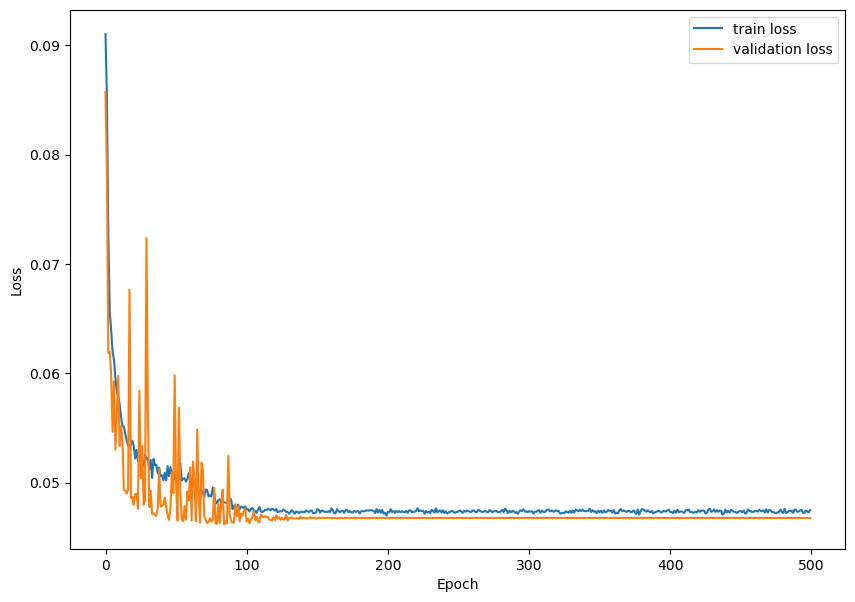

In [148]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [149]:
pred = model.predict(test_x)
df = pd.DataFrame(pred)
df

16/16 [==============================] - 0s 534us/step


,0
0,0.238538
1,0.538074
2,0.805400
3,0.435434
4,0.498264
...,...
495,0.890758
496,0.782014
497,0.540163
498,0.280162


In [150]:
tey_eye

0      0.619949
1      0.136081
2      0.721543
3      0.587172
4      0.469172
         ...   
495    0.911575
496    0.349445
497    0.430166
498    0.271961
499    0.073425
Name: eyePosition, Length: 500, dtype: float64

In [151]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(tey_eye, pred)**0.5
print(rmse)

0.21626034871692934


In [152]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(tey_eye, pred)
print(mae)

0.1720287768167207
